In [1]:
# STEM GPT: A chatbot that helps us analyze biological TEM data with auto segmentation.

# Environment & data loading

This section installs required packages (if missing), lists `.tif` images in `data/`, and provides an interactive selector and a programmatic query option to load and inspect an image.

In [2]:
# Install and import required packages (installs missing ones automatically)
import sys, subprocess

def ensure_import(pkg_name, import_name=None):
    import importlib
    try:
        importlib.import_module(import_name or pkg_name)
    except ImportError:
        print(f"Installing {pkg_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name])

for pkg, name in [("tifffile", "tifffile"), ("scikit-image", "skimage"), ("ipywidgets", "ipywidgets"), ("matplotlib", "matplotlib"), ("numpy", "numpy")]:
    ensure_import(pkg, name)

# Imports
from pathlib import Path
import os
import tifffile
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

plt.rcParams['figure.dpi'] = 100

In [3]:
# Chat UI (uses consolidated `process_command` and `state` helpers)
from ipywidgets import Text, Button, HBox, Output

input_box = Text(placeholder='Type commands like: list files | show <name> | stats | segment mitochondria', description='Query:')
send_btn = Button(description='Send')
chat_out = Output(layout={'border': '1px solid #ddd'})


def append(role, text):
    with chat_out:
        print(f"{role}: {text}")


def _on_send(b):
    text = input_box.value.strip()
    if not text:
        return
    append('User', text)
    resp = process_command(text, state, out=chat_out)
    append('Bot', resp)
    input_box.value = ''

send_btn.on_click(_on_send)

# Show the widgets
display(HBox([input_box, send_btn]), chat_out)
append('System', "Tip: try 'list files', 'show <name>', 'stats', 'segment mitochondria' or 'help'.")

Output(layout=Layout(border_bottom='1px solid #ddd', border_left='1px solid #ddd', border_right='1px solid #dd…

## Refactor: Consolidated utilities and command processor

This cell consolidates image I/O, display, statistics, segmentation, and the command parser into a single, reusable utilities module.

Run this cell before running the chat UI cell so the helpers are available to the UI.

In [4]:
# Ensure Pillow is installed for image serialization
import sys, subprocess
try:
    from PIL import Image
except Exception:
    print('Installing pillow...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'pillow'])
    from PIL import Image
    print('pillow installed')

In [5]:
# Ensure pandas is installed (needed for metric extraction)
import sys, subprocess
try:
    import pandas as pd
except ImportError:
    print('Installing pandas...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'pandas'])
    import pandas as pd
    print('pandas installed')

In [6]:
# Utilities: consolidated helpers + TEMToolbox
from pathlib import Path
import os
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from difflib import get_close_matches
from skimage import filters, morphology, measure
from IPython.display import display
from PIL import Image
import io, base64

plt.rcParams['figure.dpi'] = 100

DATA_DIR = Path("data")

# --- low-level helpers (unchanged behavior) ---

def list_tif_files():
    return sorted(DATA_DIR.glob("*.tif"))


def choose_by_query(query, files=None):
    if not query:
        return None
    files = files or list_tif_files()
    for p in files:
        if Path(query).name == p.name or query in p.name:
            return p
    names = [p.name for p in files]
    matches = get_close_matches(query, names, n=1, cutoff=0.4)
    if matches:
        m = matches[0]
        return Path(m) if Path(m).is_absolute() else DATA_DIR / m
    return None


def load_image(path):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(path)
    img = tifffile.imread(path)
    if img.ndim == 3 and img.shape[0] > 1 and img.shape[1] == img.shape[2]:
        img = img[0]
    return np.squeeze(img)


def image_to_png_bytes(img_array, cmap='gray'):
    """Return PNG bytes for a numpy image (2D or 3D)."""
    arr = np.asarray(img_array)
    if arr.ndim == 2:
        # convert to 8-bit for display
        vmin, vmax = arr.min(), arr.max()
        if vmax > vmin:
            norm = (arr - vmin) / (vmax - vmin)
        else:
            norm = np.zeros_like(arr, dtype=np.float32)
        rgb = (plt.cm.gray(norm)[:, :, :3] * 255).astype(np.uint8)
    elif arr.ndim == 3 and arr.shape[2] in (3,4):
        rgb = arr.astype(np.uint8)
    else:
        # fallback: show first channel
        rgb = np.squeeze(arr)
        if rgb.ndim == 2:
            vmin, vmax = rgb.min(), rgb.max()
            if vmax > vmin:
                norm = (rgb - vmin) / (vmax - vmin)
            else:
                norm = np.zeros_like(rgb, dtype=np.float32)
            rgb = (plt.cm.gray(norm)[:, :, :3] * 255).astype(np.uint8)
        else:
            rgb = (rgb * 255).astype(np.uint8)
    im = Image.fromarray(rgb)
    buf = io.BytesIO()
    im.save(buf, format='PNG')
    return buf.getvalue()


def overlay_mask_on_image(img_array, mask_bool, color=(255,0,0), alpha=0.35):
    """Return PNG bytes of overlay image (RGB) where mask is shown with given color and alpha."""
    img = np.asarray(img_array)
    # create background RGB
    if img.ndim == 2:
        vmin, vmax = img.min(), img.max()
        if vmax > vmin:
            norm = (img - vmin) / (vmax - vmin)
        else:
            norm = np.zeros_like(img, dtype=np.float32)
        bg = (plt.cm.gray(norm)[:, :, :3] * 255).astype(np.uint8)
    elif img.ndim == 3 and img.shape[2] in (3,4):
        bg = img.astype(np.uint8)[:, :, :3]
    else:
        bg = np.tile((img / np.max(img) * 255).astype(np.uint8)[..., None], (1,1,3))
    fg = bg.copy()
    mask = np.asarray(mask_bool).astype(bool)
    fg[mask] = (np.array(color, dtype=np.uint8) * 1.0).astype(np.uint8)
    # blend
    out = (bg * (1-alpha) + fg * alpha).astype(np.uint8)
    im = Image.fromarray(out)
    buf = io.BytesIO()
    im.save(buf, format='PNG')
    return buf.getvalue()


def image_bytes_to_base64_str(b):
    return base64.b64encode(b).decode('ascii')


# --- metric & segmentation helpers (expanded) ---


def image_stats(img, out=None):
    arr = np.asarray(img)
    summary = f"dtype:{arr.dtype} shape:{arr.shape} min:{arr.min()} max:{arr.max()} mean:{float(arr.mean()):.3f}"
    if out is None:
        print(summary)
        plt.figure(figsize=(5,2)); plt.hist(arr.ravel(), bins=256); plt.title('Pixel intensity histogram'); plt.show()
    else:
        with out:
            print(summary)
            plt.figure(figsize=(5,2)); plt.hist(arr.ravel(), bins=256); plt.title('Pixel intensity histogram'); plt.show()
    return summary


def segment_mitochondria(img, min_size=50):
    imgf = img.astype(np.float32)
    try:
        thresh = filters.threshold_otsu(imgf)
    except Exception:
        thresh = np.percentile(imgf, 50)
    bw = imgf > thresh
    bw = morphology.remove_small_objects(bw.astype(bool), min_size=min_size)
    bw = morphology.binary_closing(bw, morphology.disk(2))
    labels = measure.label(bw)
    props = measure.regionprops(labels)
    areas = [p.area for p in props]
    return {'mask': bw, 'labels': labels, 'count': len(props), 'areas': areas, 'thresh': float(thresh)}


def segment_nuclei(img, min_size=500):
    """Segment nuclei by smoothing + thresholding + hole-filling.
    Returns the same dict structure as other segment_* helpers."""
    imgf = img.astype(np.float32)
    # smooth to reduce small texture
    img_s = filters.gaussian(imgf, sigma=2)
    try:
        thresh = filters.threshold_otsu(img_s)
    except Exception:
        thresh = np.percentile(img_s, 50)
    bw = img_s > thresh
    # remove small noisy objects and close gaps
    bw = morphology.remove_small_objects(bw.astype(bool), min_size=min_size)
    bw = morphology.binary_closing(bw, morphology.disk(5))
    # remove small holes (area threshold relative to min_size)
    bw = morphology.remove_small_holes(bw, area_threshold=max(64, min_size*2))
    labels = measure.label(bw)
    props = measure.regionprops(labels)
    areas = [p.area for p in props]
    return {'mask': bw, 'labels': labels, 'count': len(props), 'areas': areas, 'thresh': float(thresh)}


def segment_membrane(img, sigma=1.0, edge_thresh=None):
    """Detect membrane-like thin structures using an edge detector + dilation.
    This produces a mask of membrane pixels rather than compact objects.
    """
    imgf = img.astype(np.float32)
    # compute edge strength
    edge = filters.sobel(imgf)
    if edge_thresh is None:
        try:
            edge_thresh = filters.threshold_otsu(edge)
        except Exception:
            edge_thresh = np.percentile(edge, 75)
    bw = edge > edge_thresh
    # make membranes thicker for visualization and measurements
    bw = morphology.binary_dilation(bw, morphology.disk(2))
    bw = morphology.remove_small_objects(bw.astype(bool), min_size=20)
    labels = measure.label(bw)
    props = measure.regionprops(labels)
    areas = [p.area for p in props]
    return {'mask': bw, 'labels': labels, 'count': len(props), 'areas': areas, 'edge_thresh': float(edge_thresh)}


def segment_feature(img, feature='mitochondria', **kwargs):
    feature = feature.lower()
    if feature in ('mito', 'mitochondria'):
        return segment_mitochondria(img, **kwargs)
    if feature in ('nucleus', 'nuclei'):
        return segment_nuclei(img, **kwargs)
    if feature in ('membrane', 'cell membrane', 'membranes'):
        return segment_membrane(img, **kwargs)
    raise ValueError(f"Unknown feature to segment: {feature}")


def extract_metrics(labels, img):
    """Extract shape and intensity metrics from labeled segmentation as a pandas DataFrame."""
    props = measure.regionprops(labels, intensity_image=img)
    rows = []
    for prop in props:
        r = {
            'label': int(prop.label),
            'area': int(prop.area),
            'perimeter': float(prop.perimeter) if hasattr(prop, 'perimeter') else np.nan,
            'eccentricity': float(prop.eccentricity),
            'solidity': float(prop.solidity),
            'mean_intensity': float(prop.mean_intensity) if hasattr(prop, 'mean_intensity') else np.nan,
            'centroid_row': float(prop.centroid[0]),
            'centroid_col': float(prop.centroid[1]),
            'bbox_minr': int(prop.bbox[0]),
            'bbox_minc': int(prop.bbox[1]),
            'bbox_maxr': int(prop.bbox[2]),
            'bbox_maxc': int(prop.bbox[3])
        }
        rows.append(r)
    df = pd.DataFrame(rows)
    # keep pixel-area units; user can convert to physical units if pixel_size known
    return df


def save_metrics_to_csv(df, filename='metrics.csv'):
    df.to_csv(filename, index=False)
    return filename


# --- NEW: summary & plotting helpers for metrics (unchanged) ---

def summarize_metrics_df(df):
    if df is None or df.empty:
        return {'count':0,'area_mean':np.nan,'area_median':np.nan,'area_std':np.nan}
    return {'count': len(df), 'area_mean': float(df['area'].mean()), 'area_median': float(df['area'].median()), 'area_std': float(df['area'].std())}


def plot_metric_histogram(df1, df2=None, labels=('A','B'), metric='area', bins=30):
    plt.figure(figsize=(8,4))
    ax1 = plt.subplot(1,2,1)
    if df2 is None:
        ax1.hist(df1[metric].dropna(), bins=bins, alpha=0.7)
        ax1.set_title(f"{labels[0]} {metric} histogram")
    else:
        ax1.hist(df1[metric].dropna(), bins=bins, alpha=0.6, label=labels[0])
        ax1.hist(df2[metric].dropna(), bins=bins, alpha=0.6, label=labels[1])
        ax1.legend()
        ax1.set_title(f"{metric} histogram")

    ax2 = plt.subplot(1,2,2)
    if df2 is None:
        ax2.boxplot(df1[metric].dropna())
        ax2.set_title(f"{labels[0]} {metric} boxplot")
    else:
        data = [df1[metric].dropna(), df2[metric].dropna()]
        ax2.boxplot(data, labels=labels)
        ax2.set_title(f"{metric} boxplot comparison")
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    return buf.getvalue()


# --- TEMToolbox: extend with comparison/plotting utilities ---
class TEMToolbox:
    """Lightweight programmatic API for listing, loading, segmenting, and extracting metrics from TEM images.
    Methods return serializable dicts and/or image bytes so they are easy to use from a chatbot or a web server.
    """
    def __init__(self, data_dir=DATA_DIR):
        self.data_dir = Path(data_dir)
        self.state = {'current_path': None, 'current_img': None, 'last_segmentation': None, 'metrics_df': None}

    def list_files(self):
        return [p.name for p in sorted(self.data_dir.glob('*.tif'))]

    def load(self, name_or_path):
        path = choose_by_query(name_or_path, files=list(self.data_dir.glob('*.tif')))
        if path is None:
            raise FileNotFoundError(name_or_path)
        img = load_image(path)
        self.state['current_path'] = path
        self.state['current_img'] = img
        self.state['last_segmentation'] = None
        self.state['metrics_df'] = None
        return {'name': path.name, 'shape': img.shape, 'dtype': str(img.dtype)}

    def get_image_bytes(self):
        img = self.state['current_img']
        if img is None:
            return None
        return image_to_png_bytes(img)

    def segment(self, min_size=50, feature='mitochondria', **kwargs):
        """Segment the specified feature on the currently loaded image.
        feature: 'mitochondria'|'nuclei'|'membrane'
        Additional kwargs are passed to the underlying segmentation routine.
        """
        img = self.state['current_img']
        if img is None:
            raise RuntimeError('No image loaded')
        res = segment_feature(img, feature=feature, min_size=min_size, **kwargs)
        # tag which feature was segmented
        res['feature'] = feature
        self.state['last_segmentation'] = res
        if res['count'] > 0:
            df = extract_metrics(res['labels'], img)
            self.state['metrics_df'] = df
        else:
            self.state['metrics_df'] = pd.DataFrame()

        # choose overlay color by feature for easy visual distinction
        color_map = {
            'mitochondria': (255,0,0),
            'mito': (255,0,0),
            'nuclei': (0,0,255),
            'nucleus': (0,0,255),
            'membrane': (0,255,0),
            'cell membrane': (0,255,0)
        }
        color = color_map.get(feature.lower(), (255,0,0))
        overlay_bytes = overlay_mask_on_image(img, res['mask'], color=color)
        return {'count': res['count'], 'areas': res['areas'], 'meta': {k:v for k,v in res.items() if k not in ('mask','labels')}, 'overlay_png': overlay_bytes}

    def get_metrics(self):
        df = self.state.get('metrics_df')
        if df is None:
            return None
        return {'rows': df.to_dict(orient='records'), 'csv': df.to_csv(index=False)}

    def export_metrics(self, filename='metrics.csv'):
        df = self.state.get('metrics_df')
        if df is None:
            raise RuntimeError('No metrics to export')
        save_metrics_to_csv(df, filename)
        return filename

    def show_last_overlay_base64(self):
        seg = self.state.get('last_segmentation')
        img = self.state.get('current_img')
        if seg is None or img is None:
            return None
        b = overlay_mask_on_image(img, seg['mask'])
        return image_bytes_to_base64_str(b)

    # --- NEW: summaries, plotting and comparison methods ---
    def summarize_metrics(self):
        df = self.state.get('metrics_df')
        return summarize_metrics_df(df)

    def plot_metrics(self, other_toolbox=None, metric='area'):
        df1 = self.state.get('metrics_df')
        if df1 is None:
            raise RuntimeError('No metrics available to plot for the current image')
        df2 = None
        labels = ('A','B')
        if other_toolbox is not None:
            df2 = other_toolbox.state.get('metrics_df')
            labels = (self.state['current_path'].name if self.state['current_path'] else 'A', other_toolbox.state['current_path'].name if other_toolbox.state['current_path'] else 'B')
        png = plot_metric_histogram(df1, df2, labels=labels, metric=metric)
        return png

    def compare_images(self, name1, name2, min_size=50):
        # helper that loads and segments two images and returns summaries + comparison plot
        tb1 = TEMToolbox(self.data_dir)
        tb2 = TEMToolbox(self.data_dir)
        tb1.load(name1)
        tb2.load(name2)
        tb1.segment(min_size=min_size)
        tb2.segment(min_size=min_size)
        s1 = tb1.summarize_metrics()
        s2 = tb2.summarize_metrics()
        plot_png = tb1.plot_metrics(other_toolbox=tb2)
        return {'summary_a': s1, 'summary_b': s2, 'plot_png': plot_png}


# Instantiate a notebook-level toolbox for convenience
toolbox = TEMToolbox(DATA_DIR)

# Backwards-compatible: keep process_command but delegate to toolbox where appropriate
def process_command(text, state, out=None):
    t = text.lower().strip()
    if t in ('help', '?'):
        return (
            "Commands:\n"
            " - list files\n"
            " - show <name>\n"
            " - stats\n"
            " - segment <mitochondria|nuclei|membrane>\n"
            " - metrics\n"
            " - export metrics <filename.csv>\n"
            " - compare <name1> <name2>\n"
            " - plot metrics <name?>\n"
            " - help"
        )
    if 'list' in t or 'files' in t:
        return "\n".join(toolbox.list_files())
    if 'show' in t or 'display' in t:
        rest = text.partition('show')[-1].strip() or text.partition('display')[-1].strip()
        try:
            info = toolbox.load(rest or toolbox.list_files()[0])
            # display image in notebook UI if requested
            if out is not None:
                with out:
                    b = toolbox.get_image_bytes()
                    display(Image.open(io.BytesIO(b)))
            return f"Loaded {info['name']} (shape={info['shape']}, dtype={info['dtype']})"
        except Exception as e:
            return f"Error loading '{rest}': {e}"
    if 'stats' in t:
        if toolbox.state['current_img'] is None:
            return "No image loaded. Use 'show <name>'."
        return image_stats(toolbox.state['current_img'], out=out)
    if 'segment' in t:
        if toolbox.state['current_img'] is None:
            return "No image loaded to segment. Use 'show <name>' first."
        feature = 'mitochondria'
        if 'nuclei' in t or 'nucleus' in t:
            feature = 'nuclei'
        if 'membrane' in t:
            feature = 'membrane'
        res = toolbox.segment(feature=feature)
        if out is not None:
            with out:
                display(Image.open(io.BytesIO(res['overlay_png'])))
                if toolbox.state['metrics_df'] is not None and not toolbox.state['metrics_df'].empty:
                    display(toolbox.state['metrics_df'].head())
        return f"Segmentation complete: found {res['count']} objects for {feature}; metrics computed (use 'metrics' to view)."
    if 'metrics' in t and 'export' not in t and 'save' not in t:
        m = toolbox.get_metrics()
        if out is not None:
            with out:
                if m is None or len(m['rows']) == 0:
                    print('No metrics available')
                else:
                    display(pd.DataFrame(m['rows']))
        return f"Metrics ready: {len(m['rows']) if m else 0} rows" if m else "Metrics are empty"
    if ('export' in t or 'save' in t) and 'metrics' in t:
        parts = text.split()
        fname = None
        for p in parts[parts.index('metrics')+1:]:
            if p.endswith('.csv'):
                fname = p
                break
        if fname is None:
            fname = 'metrics.csv'
        try:
            saved = toolbox.export_metrics(filename=fname)
            return f"Metrics saved to {saved}"
        except Exception as e:
            return f"Export failed: {e}"
    if t.startswith('compare'):
        parts = text.split()
        if len(parts) < 3:
            return "Usage: compare <image1> <image2>"
        name1, name2 = parts[1], parts[2]
        try:
            res = toolbox.compare_images(name1, name2)
            if out is not None:
                with out:
                    display(Image.open(io.BytesIO(res['plot_png'])))
            s1 = res['summary_a']
            s2 = res['summary_b']
            return f"Compare: {name1}: count={s1['count']}, mean_area={s1['area_mean']:.1f} | {name2}: count={s2['count']}, mean_area={s2['area_mean']:.1f}"
        except Exception as e:
            return f"Compare failed: {e}"
    if t.startswith('plot') and 'metrics' in t:
        # plot metrics for current image or provided image
        parts = text.split()
        if len(parts) == 1 or parts[-1] == 'metrics':
            try:
                png = toolbox.plot_metrics()
                if out is not None:
                    with out:
                        display(Image.open(io.BytesIO(png)))
                return "Plotted metrics for current image"
            except Exception as e:
                return f"Plot failed: {e}"
        else:
            # user provided an image name to plot
            name = parts[-1]
            try:
                tb = TEMToolbox(DATA_DIR)
                tb.load(name)
                tb.segment()
                png = tb.plot_metrics()
                if out is not None:
                    with out:
                        display(Image.open(io.BytesIO(png)))
                return f"Plotted metrics for {name}"
            except Exception as e:
                return f"Plot failed: {e}"
    matched = choose_by_query(text)
    if matched:
        try:
            info = toolbox.load(matched)
            if out is not None:
                with out:
                    b = toolbox.get_image_bytes()
                    display(Image.open(io.BytesIO(b)))
            return f"Loaded {info['name']}"
        except Exception as e:
            return f"Error loading matched image: {e}"
    return "Sorry, I didn't understand that. Type 'help' for commands."

In [7]:
# Backwards compatibility: expose `state` expected by older cells
# Some cells (e.g., the Chat UI) reference `state` directly; link it to the toolbox state.
state = toolbox.state
print('Linked global variable `state` to toolbox.state (keys:)', list(state.keys()))

Linked global variable `state` to toolbox.state (keys:) ['current_path', 'current_img', 'last_segmentation', 'metrics_df']


In [8]:
# Notebook startup — lists files and optionally auto-loads QUERY_IMAGE
import os
files = list_tif_files()
if files:
    print(f"Found {len(files)} .tif files in {DATA_DIR.resolve()}:")
    for i,p in enumerate(files[:50], 1):
        print(f"{i}. {p.name}")
else:
    print(f"No .tif files found in {DATA_DIR.resolve()}. Place your .tif files in the data/ folder.")

q = os.environ.get('QUERY_IMAGE')
if q:
    print(f"QUERY_IMAGE is set to: {q} — attempting to load...")
    try:
        # use process_command so behavior is consistent
        resp = process_command(f"show {q}", state, out=None)
        print(resp)
    except Exception as e:
        print(f"Auto-load failed: {e}")
else:
    print("No QUERY_IMAGE set — to auto-load an image set the env var or use the chat UI with 'show <name>'.")

Found 6 .tif files in C:\Users\bridg\OneDrive\Documents\Coding_Projects\hackathon\data:
1. 10788.tif
2. 10790.tif
3. 10970.tif
4. 11458.tif
5. 6516.tif
6. 6518.tif
No QUERY_IMAGE set — to auto-load an image set the env var or use the chat UI with 'show <name>'.


In [9]:
# Demo: programmatic test of TEMToolbox (no chat UI needed)
# This cell shows how a chatbot or a server could call the API. Run it to test locally.

print('Files:', toolbox.list_files())
if toolbox.list_files():
    name = toolbox.list_files()[0]
    print('\nLoading:', name)
    print(toolbox.load(name))

    print('\nRunning segmentation...')
    segres = toolbox.segment(min_size=20)
    print('Found objects:', segres['count'])

    print('\nMetrics summary:')
    m = toolbox.get_metrics()
    if m and m['rows']:
        df = pd.DataFrame(m['rows'])
        display(df.head())
        # save demo metrics into the outputs/ directory so artifacts are organized
        out_dir = Path('outputs')
        out_dir.mkdir(exist_ok=True)
        fname = out_dir / 'demo_metrics.csv'
        toolbox.export_metrics(str(fname))
        print('Saved metrics to', fname.resolve())

    # Save overlay PNG for inspection
    overlay_b = segres.get('overlay_png')
    if overlay_b:
        out_dir = Path('outputs')
        out_dir.mkdir(exist_ok=True)
        p = out_dir / f"{name}_overlay.png"
        with open(p, 'wb') as fh:
            fh.write(overlay_b)
        print('Overlay saved to', p.resolve())
else:
    print('No files to demo with. Add .tif files to the data/ directory and rerun this cell.')

Files: ['10788.tif', '10790.tif', '10970.tif', '11458.tif', '6516.tif', '6518.tif']

Loading: 10788.tif
{'name': '10788.tif', 'shape': (1264, 906), 'dtype': 'uint8'}

Running segmentation...
Found objects: 220

Metrics summary:
Found objects: 220

Metrics summary:


label    area      perimeter  eccentricity  solidity  mean_intensity  \
0      1  657594  107363.017111      0.696256  0.574226      171.138157   
1      2     186      85.497475      0.945136  0.643599      148.494624   
2      3      20      16.485281      0.905288  0.869565      153.150000   
3      4      25      18.656854      0.973113  0.806452      147.880000   
4      5      23      22.035534      0.979208  0.766667      155.869565   

   centroid_row  centroid_col  bbox_minr  bbox_minc  bbox_maxr  bbox_maxc  
0    711.217905    484.168061          0          0       1264        906  
1     19.139785     65.817204          8         55         32         78  
2     13.250000    280.500000         11        278         17        284  
3     18.920000    700.480000         17        696         22        707  
4     24.130435    443.913043         19        442         30        446

Saved metrics to C:\Users\bridg\OneDrive\Documents\Coding_Projects\hackathon\outputs\demo_metrics.csv
Overlay saved to C:\Users\bridg\OneDrive\Documents\Coding_Projects\hackathon\outputs\10788.tif_overlay.png


Using image: 10788.tif

Segmenting feature: mitochondria
Found 220 objects (feature=mitochondria)
Saved overlay to C:\Users\bridg\OneDrive\Documents\Coding_Projects\hackathon\outputs\10788.tif_mitochondria_overlay.png
Found 220 objects (feature=mitochondria)
Saved overlay to C:\Users\bridg\OneDrive\Documents\Coding_Projects\hackathon\outputs\10788.tif_mitochondria_overlay.png


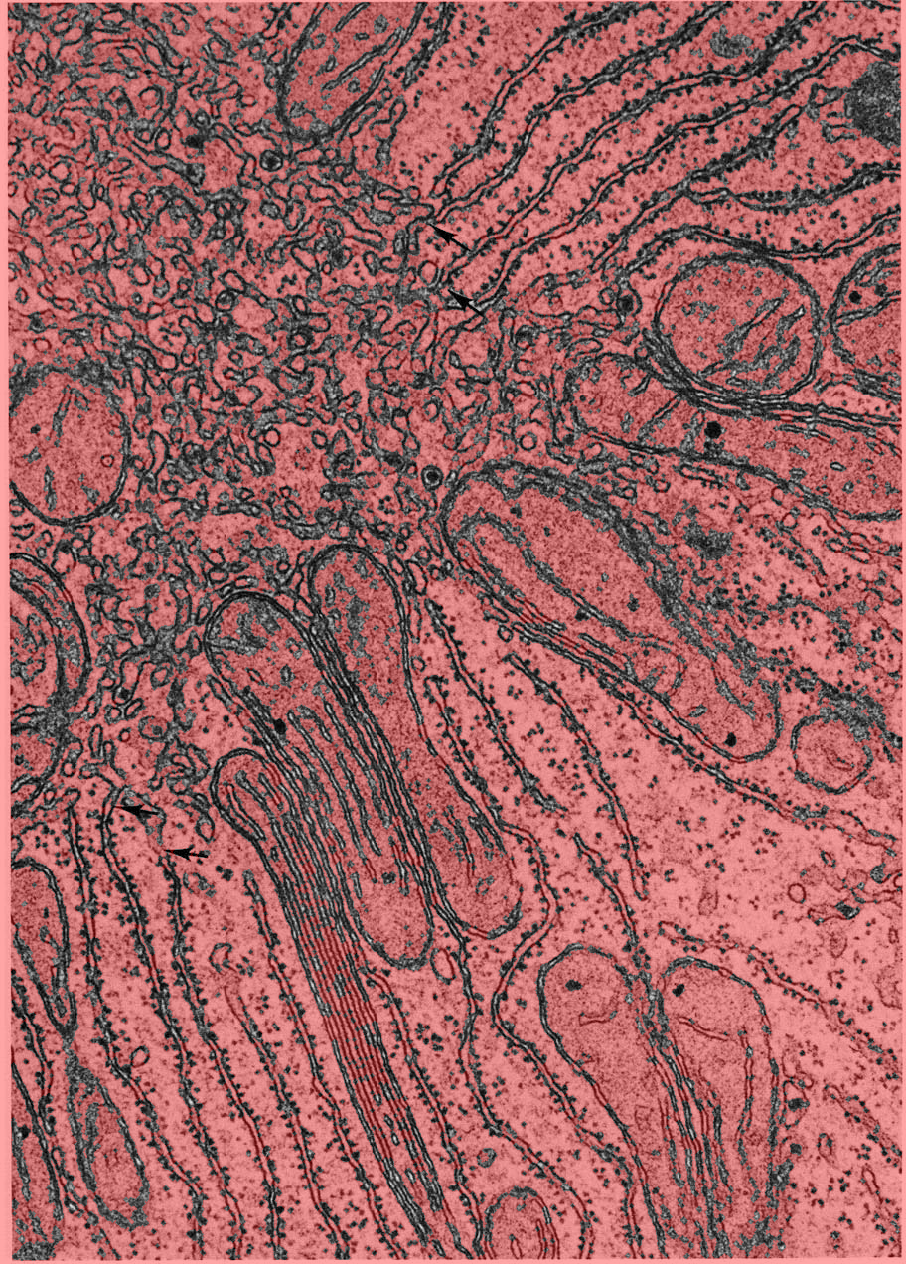

Saved metrics to C:\Users\bridg\OneDrive\Documents\Coding_Projects\hackathon\outputs\10788.tif_mitochondria_metrics.csv


label    area      perimeter  eccentricity  solidity  mean_intensity  \
0      1  657594  107363.017111      0.696256  0.574226      171.138157   
1      2     186      85.497475      0.945136  0.643599      148.494624   
2      3      20      16.485281      0.905288  0.869565      153.150000   
3      4      25      18.656854      0.973113  0.806452      147.880000   
4      5      23      22.035534      0.979208  0.766667      155.869565   

   centroid_row  centroid_col  bbox_minr  bbox_minc  bbox_maxr  bbox_maxc  
0    711.217905    484.168061          0          0       1264        906  
1     19.139785     65.817204          8         55         32         78  
2     13.250000    280.500000         11        278         17        284  
3     18.920000    700.480000         17        696         22        707  
4     24.130435    443.913043         19        442         30        446


Segmenting feature: nuclei
Found 43 objects (feature=nuclei)
Saved overlay to C:\Users\bridg\OneDrive\Documents\Coding_Projects\hackathon\outputs\10788.tif_nuclei_overlay.png
Found 43 objects (feature=nuclei)
Saved overlay to C:\Users\bridg\OneDrive\Documents\Coding_Projects\hackathon\outputs\10788.tif_nuclei_overlay.png


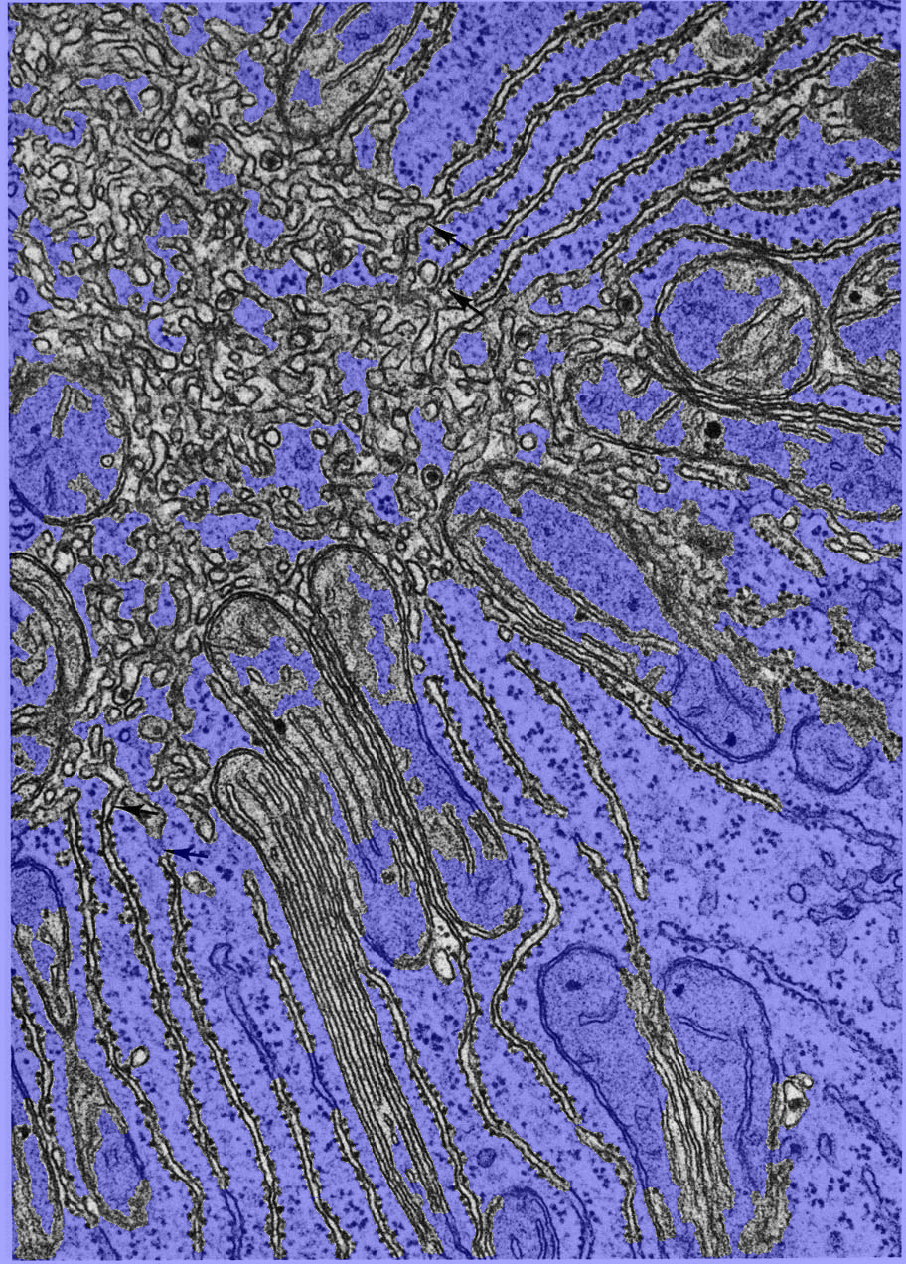

Saved metrics to C:\Users\bridg\OneDrive\Documents\Coding_Projects\hackathon\outputs\10788.tif_nuclei_metrics.csv


label    area     perimeter  eccentricity  solidity  mean_intensity  \
0      1  478742  33832.422166      0.619830  0.418048      173.217568   
1      2     608    152.509668      0.974732  0.729892      170.705592   
2      3    8781   1025.744299      0.991955  0.532246      170.338686   
3      4    1371    216.793939      0.914109  0.695233      164.696572   
4      5     903    144.468037      0.880929  0.846298      163.642303   

   centroid_row  centroid_col  bbox_minr  bbox_minc  bbox_maxr  bbox_maxc  
0    798.295944    524.041935          0          0       1264        906  
1     46.664474    410.243421         22        386         71        432  
2    153.232320    550.349618         43        416        267        705  
3     85.892779    253.433990         50        234        123        275  
4     68.873754    848.054264         53        825         87        876


Segmenting feature: membrane


TypeError: segment_membrane() got an unexpected keyword argument 'min_size'

In [10]:
# Demo: run segmentation for multiple features and save outputs
# Runs mitochondria, nuclei, and membrane segmentation on the first available image
# and writes overlays and per-feature metrics CSVs into ./outputs/

out_dir = Path('outputs')
out_dir.mkdir(exist_ok=True)

files = toolbox.list_files()
if not files:
    print('No .tif files found in data/ to run multi-feature demo. Add files and rerun this cell.')
else:
    name = files[0]
    print('Using image:', name)
    toolbox.load(name)

    for feature in ('mitochondria', 'nuclei', 'membrane'):
        print(f"\nSegmenting feature: {feature}")
        if feature == 'mitochondria':
            res = toolbox.segment(min_size=20, feature=feature)
        elif feature == 'nuclei':
            # nuclei are larger structures by default
            res = toolbox.segment(min_size=500, feature=feature)
        else:
            res = toolbox.segment(feature=feature)

        print(f"Found {res['count']} objects (feature={feature})")

        # save overlay PNG
        ov_path = out_dir / f"{name}_{feature}_overlay.png"
        with open(ov_path, 'wb') as fh:
            fh.write(res['overlay_png'])
        print('Saved overlay to', ov_path.resolve())

        # display in-notebook for quick check
        display(Image.open(io.BytesIO(res['overlay_png'])))

        # save metrics CSV if available
        m = toolbox.get_metrics()
        if m and m['rows']:
            csv_path = out_dir / f"{name}_{feature}_metrics.csv"
            toolbox.export_metrics(str(csv_path))
            print('Saved metrics to', csv_path.resolve())
            # show a preview
            display(pd.DataFrame(m['rows']).head())
        else:
            print('No metrics produced for', feature)

    print('\nMulti-feature demo complete. Outputs saved to', out_dir.resolve())

In [ ]:
# Demo: compare two images programmatically (run to test)
files = toolbox.list_files()
if len(files) >= 2:
    a, b = files[0], files[1]
    print('Comparing', a, 'vs', b)
    res = toolbox.compare_images(a, b)
    print('Summary A:', res['summary_a'])
    print('Summary B:', res['summary_b'])
    # write plot for inspection
    out_dir = Path('outputs')
    out_dir.mkdir(exist_ok=True)
    p = out_dir / f"compare_{a}_vs_{b}.png"
    with open(p, 'wb') as fh:
        fh.write(res['plot_png'])
    print('Saved comparison plot to', p.resolve())
else:
    print('Need at least two .tif files in data/ to run comparison demo.')

Comparing 10788.tif vs 10790.tif


C:\Users\bridg\AppData\Local\Temp\ipykernel_31348\1032170455.py:196: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(data, labels=labels)


Summary A: {'count': 142, 'area_mean': 5032.80985915493, 'area_median': 131.5, 'area_std': 50737.12493495978}
Summary B: {'count': 37, 'area_mean': 20297.891891891893, 'area_median': 162.0, 'area_std': 121180.58179308355}
Saved comparison plot to C:\Users\bridg\OneDrive\Documents\Coding_Projects\hackathon\outputs\compare_10788.tif_vs_10790.tif.png
